In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from collections import Counter
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix,precision_recall_fscore_support

In [2]:
df=pd.read_csv('ks-projects-201801.csv',encoding= 'latin_1')
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [3]:
df.columns

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real'],
      dtype='object')

今回の方針  
#### nameは~~扱いが難しいので削除~~
### 文字数にするといいというアドバイスがあったので文字数or単語数でデータ化する
categoryは数が多すぎる、分類が細かすぎるので削除、使用しない
#### main_categoryは~~種類毎に数字化する~~
### onehotで分類する
#### currencyはcountryと相関が高そうだがとりあえず~~数字化する~~
### onehotで分類する
deadlineはとりあえず数字化するけど、本来は月とかだけでもいいかもしれない  
goalは使用しない、目標額にはusd_goal_realを使用する  
#### launchedは開始時刻、~~これは推定をするときにはわからないデータとして判断すると削除する方針~~ 
### こういったプロジェクトは任意に開始時刻が決定できるらしいので使用するにする
pledgedは到達金額、つまり結果の事なので、今回の分類には使用しない  
stateは目的変数として使用する  
backersは支援者の数、これも結果なので、今回は使用しない  
countryは数字化するが、アメリカが多すぎるのでどう対応するかは迷う  
usd pledgedは結果なので使用しない。  
usd_goal_realは使用する。

### 目的変数

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64


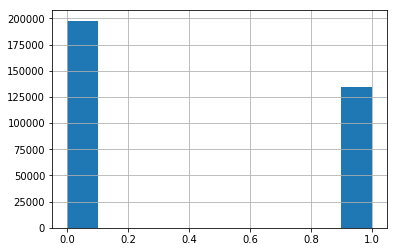

In [4]:
print(df['state'].value_counts())
dft=df.copy()
dft.drop(dft.index[dft.state == 'canceled'],inplace=True)
dft.drop(dft.index[dft.state == 'undefined'],inplace=True)
dft.drop(dft.index[dft.state == 'live'],inplace=True)
dft.drop(dft.index[dft.state == 'suspended'],inplace=True)
dft['state']=dft['state'].replace('failed',0)
dft['state']=dft['state'].replace('successful',1)
dft=dft.reset_index(drop=True)
dft['state'].hist(bins=10)

### 使わないデータの削除

In [5]:
dft=dft.drop(['ID','category','usd pledged','goal','pledged','backers','usd_pledged_real'],axis=1)
dft.head()

,name,main_category,currency,deadline,launched,state,country,usd_goal_real
0,The Songs of Adelaide & Abullah,Publishing,GBP,2015-10-09,2015-08-11 12:12:28,0,GB,1533.95
1,Greeting From Earth: ZGAC Arts Capsule For ET,Film & Video,USD,2017-11-01,2017-09-02 04:43:57,0,US,30000.00
2,Where is Hank?,Film & Video,USD,2013-02-26,2013-01-12 00:20:50,0,US,45000.00
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,USD,2012-04-16,2012-03-17 03:24:11,0,US,5000.00
4,Monarch Espresso Bar,Food,USD,2016-04-01,2016-02-26 13:38:27,1,US,50000.00


In [6]:
dft=dft.loc[:,['state','main_category', 'currency','country','usd_goal_real', 'name','deadline','launched']]
dft.head()

,state,main_category,currency,country,usd_goal_real,name,deadline,launched
0,0,Publishing,GBP,GB,1533.95,The Songs of Adelaide & Abullah,2015-10-09,2015-08-11 12:12:28
1,0,Film & Video,USD,US,30000.00,Greeting From Earth: ZGAC Arts Capsule For ET,2017-11-01,2017-09-02 04:43:57
2,0,Film & Video,USD,US,45000.00,Where is Hank?,2013-02-26,2013-01-12 00:20:50
3,0,Music,USD,US,5000.00,ToshiCapital Rekordz Needs Help to Complete Album,2012-04-16,2012-03-17 03:24:11
4,1,Food,USD,US,50000.00,Monarch Espresso Bar,2016-04-01,2016-02-26 13:38:27


### 欠損値の確認と除去

In [7]:
dft.isnull().sum()

state            0
main_category    0
currency         0
country          0
usd_goal_real    0
name             3
deadline         0
launched         0
dtype: int64

In [8]:
dft=dft.dropna()
dft.isnull().sum()

state            0
main_category    0
currency         0
country          0
usd_goal_real    0
name             0
deadline         0
launched         0
dtype: int64

### nameを文字数化する

In [9]:
dft['words'] = dft['name'].apply(lambda x: len(Counter(str(x).split())))

### nameを最頻単語100個分をダミー変数化する

In [10]:
test =Counter(str(dft['name']).split())
for w in test.most_common():
    print(w)

('The', 10)
('-', 8)
('&', 6)
('the', 5)
('of', 4)
('...', 4)
('for', 4)
('A', 4)
('is', 3)
('to', 3)
('Album', 3)
('Coffee', 3)
('Tea', 3)
('in', 3)
('From', 2)
('Needs', 2)
('Bar', 2)
('make', 2)
('their', 2)
('Of', 2)
('and', 2)
('New', 2)
('Life', 2)
('G', 2)
('Book', 2)
('My', 2)
('Moon', 2)
('Film', 2)
('Pug', 2)
('cards', 2)
('You', 2)
('0', 1)
('Songs', 1)
('Adelaide', 1)
('Abullah', 1)
('1', 1)
('Greeting', 1)
('Earth:', 1)
('ZGAC', 1)
('Arts', 1)
('Capsule', 1)
('For', 1)
('ET', 1)
('2', 1)
('Where', 1)
('Hank?', 1)
('3', 1)
('ToshiCapital', 1)
('Rekordz', 1)
('Help', 1)
('Complete', 1)
('4', 1)
('Monarch', 1)
('Espresso', 1)
('5', 1)
('Support', 1)
('Solar', 1)
('Roasted', 1)
('Green', 1)
('Energy!', 1)
('6', 1)
('Chaser', 1)
('Strips.', 1)
('Our', 1)
('Strips', 1)
('Shots', 1)
('B*tch!', 1)
('7', 1)
('Jesus', 1)
('Madmen', 1)
('8', 1)
('Lisa', 1)
('Lim', 1)
('CD!', 1)
('9', 1)
('Cottage', 1)
('Market', 1)
('10', 1)
('G-Spot', 1)
('Place', 1)
('Gamers', 1)
('connect', 1)
('w

重複している単語があまりに少ないので、説明変数にするのはやめる

解析が間違っている！？

### 期間、終了月、終了日は投資側の都合が絡んでくると思われるので説明変数化する

In [11]:
dft['deadmonth'] = pd.to_datetime(dft['deadline']).dt.month
dft['deadday'] = pd.to_datetime(dft['deadline']).dt.day

In [12]:
dft['period'] = (pd.to_datetime(dft['deadline']) - pd.to_datetime(dft['launched'])).dt.days

In [13]:
# pd.plotting.scatter_matrix(dft, figsize=(10,10))
# plt.show()

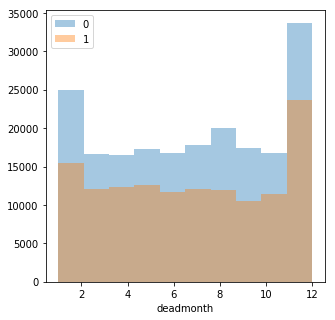

In [14]:
plt.figure(figsize=(5,5))
sns.distplot(dft[dft['state']==0]['deadmonth'],kde=False,rug=False,bins=10,label='0')
sns.distplot(dft[dft['state']==1]['deadmonth'],kde=False,rug=False,bins=10,label='1')
plt.legend()
plt.show()

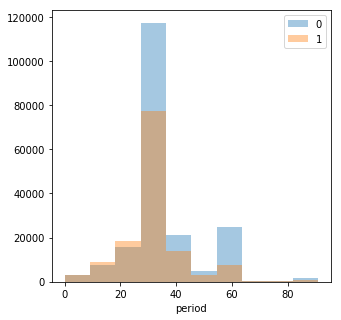

In [15]:
plt.figure(figsize=(5,5))
sns.distplot(dft[dft['state']==0]['period'],kde=False,rug=False,bins=10,label='0')
sns.distplot(dft[dft['state']==1]['period'],kde=False,rug=False,bins=10,label='1')
plt.legend()
plt.show()

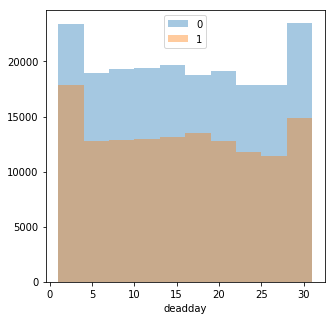

In [16]:
plt.figure(figsize=(5,5))
sns.distplot(dft[dft['state']==0]['deadday'],kde=False,rug=False,bins=10,label='0')
sns.distplot(dft[dft['state']==1]['deadday'],kde=False,rug=False,bins=10,label='1')
plt.legend()
plt.show()

### ダミー変数化

In [17]:
dft = pd.get_dummies(dft,columns={'main_category'})
dft.head()

,state,currency,country,usd_goal_real,name,deadline,launched,words,deadmonth,deadday,...,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater
0,0,GBP,GB,1533.95,The Songs of Adelaide & Abullah,2015-10-09,2015-08-11 12:12:28,6,10,9,...,0,0,0,0,0,0,0,1,0,0
1,0,USD,US,30000.00,Greeting From Earth: ZGAC Arts Capsule For ET,2017-11-01,2017-09-02 04:43:57,8,11,1,...,0,1,0,0,0,0,0,0,0,0
2,0,USD,US,45000.00,Where is Hank?,2013-02-26,2013-01-12 00:20:50,3,2,26,...,0,1,0,0,0,0,0,0,0,0
3,0,USD,US,5000.00,ToshiCapital Rekordz Needs Help to Complete Album,2012-04-16,2012-03-17 03:24:11,7,4,16,...,0,0,0,0,0,1,0,0,0,0
4,1,USD,US,50000.00,Monarch Espresso Bar,2016-04-01,2016-02-26 13:38:27,3,4,1,...,0,0,1,0,0,0,0,0,0,0


In [18]:
dft = pd.get_dummies(dft,columns={'currency'})
dft.head()

,state,country,usd_goal_real,name,deadline,launched,words,deadmonth,deadday,period,...,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
0,0,GB,1533.95,The Songs of Adelaide & Abullah,2015-10-09,2015-08-11 12:12:28,6,10,9,58,...,0,1,0,0,0,0,0,0,0,0
1,0,US,30000.00,Greeting From Earth: ZGAC Arts Capsule For ET,2017-11-01,2017-09-02 04:43:57,8,11,1,59,...,0,0,0,0,0,0,0,0,0,1
2,0,US,45000.00,Where is Hank?,2013-02-26,2013-01-12 00:20:50,3,2,26,44,...,0,0,0,0,0,0,0,0,0,1
3,0,US,5000.00,ToshiCapital Rekordz Needs Help to Complete Album,2012-04-16,2012-03-17 03:24:11,7,4,16,29,...,0,0,0,0,0,0,0,0,0,1
4,1,US,50000.00,Monarch Espresso Bar,2016-04-01,2016-02-26 13:38:27,3,4,1,34,...,0,0,0,0,0,0,0,0,0,1


### dataframe 整理

In [19]:
dft['country']=dft['country'].replace('US',1)
mask = dft.country != 1
dft.loc[mask,'country']=0

In [20]:
dft=dft.drop(['name'],axis=1)
dft.head()

,state,country,usd_goal_real,deadline,launched,words,deadmonth,deadday,period,main_category_Art,...,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
0,0,0,1533.95,2015-10-09,2015-08-11 12:12:28,6,10,9,58,0,...,0,1,0,0,0,0,0,0,0,0
1,0,1,30000.00,2017-11-01,2017-09-02 04:43:57,8,11,1,59,0,...,0,0,0,0,0,0,0,0,0,1
2,0,1,45000.00,2013-02-26,2013-01-12 00:20:50,3,2,26,44,0,...,0,0,0,0,0,0,0,0,0,1
3,0,1,5000.00,2012-04-16,2012-03-17 03:24:11,7,4,16,29,0,...,0,0,0,0,0,0,0,0,0,1
4,1,1,50000.00,2016-04-01,2016-02-26 13:38:27,3,4,1,34,0,...,0,0,0,0,0,0,0,0,0,1


In [21]:
dft=dft.drop(['deadline','launched'],axis=1)
dft.head()


,state,country,usd_goal_real,words,deadmonth,deadday,period,main_category_Art,main_category_Comics,main_category_Crafts,...,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
0,0,0,1533.95,6,10,9,58,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,1,30000.00,8,11,1,59,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,1,45000.00,3,2,26,44,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,1,5000.00,7,4,16,29,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,1,50000.00,3,4,1,34,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [22]:
dft.describe()

,state,country,usd_goal_real,words,deadmonth,deadday,period,main_category_Art,main_category_Comics,main_category_Crafts,...,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
count,331672.000000,331672.000000,3.316720e+05,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,...,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000
mean,0.403881,0.788001,4.150966e+04,5.566804,6.758499,15.271491,32.954889,0.077305,0.029782,0.023571,...,0.043350,0.088868,0.001438,0.000069,0.004254,0.001761,0.003841,0.004553,0.001369,0.788457
std,0.490675,0.408724,1.108935e+06,2.689037,3.315179,9.038861,12.713279,0.267076,0.169987,0.151710,...,0.203644,0.284553,0.037896,0.008327,0.065085,0.041925,0.061858,0.067320,0.036972,0.408403
min,0.000000,0.000000,1.000000e-02,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,2.000000e+03,3.000000,4.000000,7.000000,29.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,1.000000,5.000000e+03,5.000000,7.000000,15.000000,29.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,1.000000,1.500000e+04,8.000000,10.000000,23.000000,35.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.663614e+08,20.000000,12.000000,31.000000,91.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 標準化
min=0 max=1 以外の物を標準化する

In [23]:
# ばらつき圧縮　対数の方がいいかも
dft.usd_goal_real = np.power(dft.usd_goal_real,1/2/2/2)
dft.period = np.power(dft.period,0.25)

dft["usd_goal_real"] = (dft["usd_goal_real"] - dft["usd_goal_real"].mean()) / dft["usd_goal_real"].std(ddof=0)
dft["words"] = (dft["words"] - dft["words"].mean()) / dft["words"].std(ddof=0)
dft["deadmonth"] = (dft["deadmonth"] - dft["deadmonth"].mean()) / dft["deadmonth"].std(ddof=0)
dft["deadday"] = (dft["deadday"] - dft["deadday"].mean()) / dft["deadday"].std(ddof=0)
dft["period"] = (dft["period"] - dft["period"].mean()) / dft["period"].std(ddof=0)
dft.describe()

,state,country,usd_goal_real,words,deadmonth,deadday,period,main_category_Art,main_category_Comics,main_category_Crafts,...,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
count,331672.000000,331672.000000,3.316720e+05,3.316720e+05,3.316720e+05,3.316720e+05,3.316720e+05,331672.000000,331672.000000,331672.000000,...,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000
mean,0.403881,0.788001,-2.592337e-12,-5.594623e-16,-3.163057e-16,-4.740251e-15,-1.972236e-11,0.077305,0.029782,0.023571,...,0.043350,0.088868,0.001438,0.000069,0.004254,0.001761,0.003841,0.004553,0.001369,0.788457
std,0.490675,0.408724,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,0.267076,0.169987,0.151710,...,0.203644,0.284553,0.037896,0.008327,0.065085,0.041925,0.061858,0.067320,0.036972,0.408403
min,0.000000,0.000000,-3.833981e+00,-1.698307e+00,-1.737013e+00,-1.578906e+00,-1.014430e+01,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,-6.342891e-01,-9.545455e-01,-8.320828e-01,-9.151046e-01,-1.822806e-01,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,1.000000,-1.380954e-01,-2.107836e-01,7.284705e-02,-3.003603e-02,-1.822806e-01,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,1.000000,5.368329e-01,9.048593e-01,9.777769e-01,8.550325e-01,2.972480e-01,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.212697e+01,5.367431e+00,1.581063e+00,1.740101e+00,3.114622e+00,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


標準化の結果


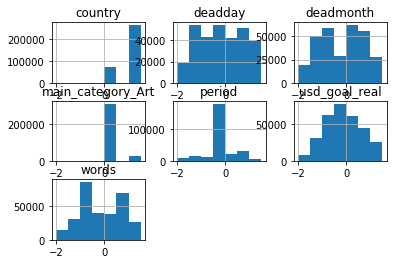

In [24]:
dft.iloc[:,1:8].hist(bins=np.arange(-2,2,0.5))
print("標準化の結果")
plt.show()

標準化の結果


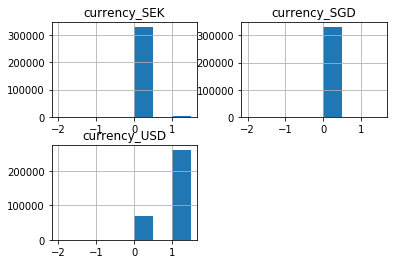

In [25]:
dft.iloc[:,33:].hist(bins=np.arange(-2,2,0.5))
print("標準化の結果")
plt.show()

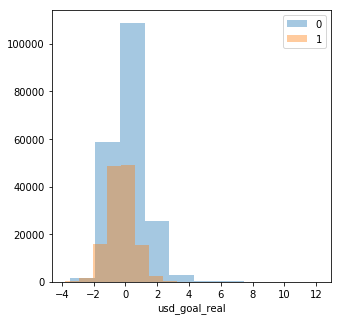

In [26]:
plt.figure(figsize=(5,5))
sns.distplot(dft[dft['state']==0]['usd_goal_real'],kde=False,rug=False,bins=10,label='0')
sns.distplot(dft[dft['state']==1]['usd_goal_real'],kde=False,rug=False,bins=10,label='1')
plt.legend()
plt.show()

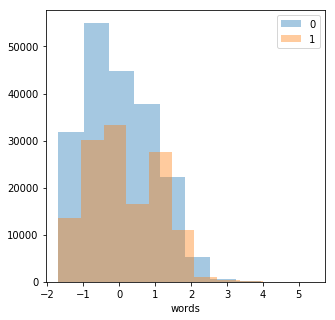

In [27]:
plt.figure(figsize=(5,5))
sns.distplot(dft[dft['state']==0]['words'],kde=False,rug=False,bins=10,label='0')
sns.distplot(dft[dft['state']==1]['words'],kde=False,rug=False,bins=10,label='1')
plt.legend()
plt.show()

### 学習実行(day1model：ロジスティック回帰)
day1:result
対数尤度 = -13.230
正答率 = 61.695%

In [28]:
y=dft.state.values
X=dft.iloc[:,1:].values
clf= SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(X, y)
y_est = clf.predict(X)
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est)))
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_est)))
conf_mat = pd.DataFrame(confusion_matrix(y, y_est), 
                        index=['正解 = 成功しない', '正解 = 成功する'], 
                        columns=['予測 = 成功しない', '予測 = 成功する'])
conf_mat

対数尤度 = -11.991
正答率 = 65.282%


,予測 = 成功しない,予測 = 成功する
正解 = 成功しない,159123,38593
正解 = 成功する,76558,57398


#### ホールドアウト法＋汎化性能検証

In [37]:
%matplotlib inline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from common_func import plot_decision_regions
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

In [30]:
y=dft.state.values
X=dft.iloc[:,1:].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=1234)

clf= SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(X_train, y_train)
y_est = clf.predict(X_train)
print('訓練性能')
print('対数尤度 = {:.3f}'.format(- log_loss(y_train, y_est)))
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_train, y_est)))
conf_mat = pd.DataFrame(confusion_matrix(y_train, y_est), 
                        index=['正解 = 成功しない', '正解 = 成功する'], 
                        columns=['予測 = 成功しない', '予測 = 成功する'])
conf_mat

訓練性能
対数尤度 = -11.955
正答率 = 65.387%


,予測 = 成功しない,予測 = 成功する
正解 = 成功しない,116912,31426
正解 = 成功する,54674,45742


In [31]:
# 汎化性能
y_est_h = clf.predict(X_test)

print('*** 汎化性能 ***')
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_est_h)))
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test, y_est_h)))
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_est_h), 
                        index=['正解 = 成功しない', '正解 = 成功する'], 
                        columns=['予測 = 成功しない', '予測 = 成功する'])
conf_mat

*** 汎化性能 ***
対数尤度 = -11.979
正答率 = 65.319%


,予測 = 成功しない,予測 = 成功する
正解 = 成功しない,38906,10472
正解 = 成功する,18285,15255


In [76]:
y=dft.state.values
X=dft.iloc[:,1:].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=1234)

clf= SGDClassifier(loss='log', penalty='l2', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-5,epsilon=1)
clf.fit(X_train, y_train)
y_est = clf.predict(X_train)
print('訓練性能')
print('対数尤度 = {:.3f}'.format(- log_loss(y_train, y_est)))
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_train, y_est)))
# 汎化性能
y_est_h = clf.predict(X_test)

print('*** 汎化性能 ***')
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_est_h)))
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test, y_est_h)))
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_est_h), 
                        index=['正解 = 成功しない', '正解 = 成功する'], 
                        columns=['予測 = 成功しない', '予測 = 成功する'])
conf_mat

訓練性能
対数尤度 = -11.972
正答率 = 65.338%
*** 汎化性能 ***
対数尤度 = -11.961
正答率 = 65.368%


,予測 = 成功しない,予測 = 成功する
正解 = 成功しない,39815,9563
正解 = 成功する,19153,14387


### SVM

In [54]:
# SVMは学習データが少なくても汎化性能が高いので、計算が処理できる程度のデータ数に制限してみる
y=dft.state.values
X=dft.iloc[:,1:].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.96,random_state=1234)
modelbaseSVC = SVC(C=1.0,kernel='linear')
modelbaseSVC.fit(X_train, y_train)
print('*** 訓練性能 ***')
print(modelbaseSVC.score(X_train, y_train))
print('*** 汎化性能 ***')
print(modelbaseSVC.score(X_test, y_test))

*** 訓練性能 ***
0.6518166742047339
*** 汎化性能 ***
0.6482415532370621


In [55]:
modelbaserbfSVC = SVC(C=1.0,kernel='rbf',gamma='scale')
modelbaserbfSVC.fit(X_train, y_train)
print('*** 訓練性能 ***')
print(modelbaserbfSVC.score(X_train, y_train))
print('*** 汎化性能 ***')
print(modelbaserbfSVC.score(X_test, y_test))

*** 訓練性能 ***
0.6806120910598522
*** 汎化性能 ***
0.6563506969089778


In [58]:
### ある程度データ数を制限した上で、GridSearchCVを使ってみる
# parameters = {'C':[0.1,1,10,100],'gamma':[0.01,0.1,1]}
# modelrbfSVC = SVC(kernel='rbf')
# clf_rbf = GridSearchCV(modelrbfSVC, parameters, cv=3,)
# clf_rbf.fit(X_train, y_train)
# print(clf_rbf.best_params_, clf_rbf.best_score_)

{'C': 100, 'gamma': 0.01} 0.6571687019448214


In [59]:
### ある程度データ数を制限した上で、GridSearchCVを使ってみる
# parameters = {'C':[50,100,1000],'gamma':[0.001,0.01,0.05]}
# modelrbfSVC = SVC(kernel='rbf')
# clf_rbf = GridSearchCV(modelrbfSVC, parameters, cv=3,)
# clf_rbf.fit(X_train, y_train)
# print(clf_rbf.best_params_, clf_rbf.best_score_)

{'C': 100, 'gamma': 0.01} 0.6571687019448214


In [60]:
### ある程度データ数を制限した上で、GridSearchCVを使ってみる
# parameters = {'C':[80,100,150],'gamma':[0.005,0.01,0.02]}
# modelrbfSVC = SVC(kernel='rbf')
# clf_rbf = GridSearchCV(modelrbfSVC, parameters, cv=3,)
# clf_rbf.fit(X_train, y_train)
# print(clf_rbf.best_params_, clf_rbf.best_score_)

{'C': 150, 'gamma': 0.01} 0.6575456053067993


In [61]:
### ある程度データ数を制限した上で、GridSearchCVを使ってみる
# parameters = {'C':[120,150,200,300],'gamma':[0.0075,0.01,0.015]}
# modelrbfSVC = SVC(kernel='rbf')
# clf_rbf = GridSearchCV(modelrbfSVC, parameters, cv=3,)
# clf_rbf.fit(X_train, y_train)
# print(clf_rbf.best_params_, clf_rbf.best_score_)

{'C': 200, 'gamma': 0.0075} 0.6581486506859641


#### ---> GridSearchCVは重要だが、あまりやりすぎてもそんなに性能は上がらない。

In [65]:
modelbestrbfSVC = SVC(C=200,kernel='rbf',gamma=0.0075)
modelbestrbfSVC.fit(X_train, y_train)
y_est = modelbestrbfSVC.predict(X_test)

print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_est)))

print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test, y_est)))

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_est)

print('Precision = {:.3f}%'.format(100 * precision[0]))
print('Recall = {:.3f}%'.format(100 * recall[0]))
print('F1-score = {:.3f}%'.format(100 * f1_score[0]))

対数尤度 = -11.966
正答率 = 65.355%
Precision = 66.331%
Recall = 85.029%
F1-score = 74.525%


In [68]:
## ある程度データ数を制限した上で、GridSearchCVを使ってみる
parameters = {'C':[0.01,0.1,1,10,100]}
modelrbfSVC = SVC(kernel='rbf',gamma='scale')
clf_rbf = GridSearchCV(modelrbfSVC, parameters, cv=3,)
clf_rbf.fit(X_train, y_train)
print(clf_rbf.best_params_, clf_rbf.best_score_)

{'C': 1} 0.6570179406000302


In [70]:
## ある程度データ数を制限した上で、GridSearchCVを使ってみる
parameters = {'C':[0.75,0.9,1,1.5,2]}
modelrbfSVC = SVC(kernel='rbf',gamma='scale')
clf_rbf = GridSearchCV(modelrbfSVC, parameters, cv=3,)
clf_rbf.fit(X_train, y_train)
print(clf_rbf.best_params_, clf_rbf.best_score_)

{'C': 1} 0.6570179406000302


### 学習実行 (多項式特徴量化：ロジスティック回帰)

In [50]:
# degree=3
# estbase = make_pipeline(PolynomialFeatures(degree), SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3))

# estbase.fit(X_train, y_train)
# y_estbase = estbase.predict(X_test)
# print('*** 汎化性能 ***')
# print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_estbase)))
# print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test, y_estbase)))
# conf_mat = pd.DataFrame(confusion_matrix(y_test, y_estbase), 
#                         index=['正解 = 成功しない', '正解 = 成功する'], 
#                         columns=['予測 = 成功しない', '予測 = 成功する'])
# conf_mat
# *** 汎化性能 ***
# 対数尤度 = -12.827
# 正答率 = 62.863%

*** 汎化性能 ***
対数尤度 = -12.827
正答率 = 62.863%


,予測 = 成功しない,予測 = 成功する
正解 = 成功しない,35380,13998
正解 = 成功する,16795,16745


#### GridSearchCVで　degreeを振りたかったができなかった。
実際メモリ不足で3以上は計算難しい

In [49]:
parameters = {'estbase__polynomialfeatures__degree':[1,3,6,10]}
estbase = make_pipeline(PolynomialFeatures(), SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3))
clf_e = GridSearchCV(estbase, parameters, cv=3,)
print(clf_e.get_params().keys())
clf_e.fit(X_train, y_train)
print(clf_e.best_params_, clf_e.best_score_)
print(cle_e.score(X_test,y_test))

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__polynomialfeatures', 'estimator__sgdclassifier', 'estimator__polynomialfeatures__degree', 'estimator__polynomialfeatures__include_bias', 'estimator__polynomialfeatures__interaction_only', 'estimator__sgdclassifier__alpha', 'estimator__sgdclassifier__average', 'estimator__sgdclassifier__class_weight', 'estimator__sgdclassifier__early_stopping', 'estimator__sgdclassifier__epsilon', 'estimator__sgdclassifier__eta0', 'estimator__sgdclassifier__fit_intercept', 'estimator__sgdclassifier__l1_ratio', 'estimator__sgdclassifier__learning_rate', 'estimator__sgdclassifier__loss', 'estimator__sgdclassifier__max_iter', 'estimator__sgdclassifier__n_iter', 'estimator__sgdclassifier__n_iter_no_change', 'estimator__sgdclassifier__n_jobs', 'estimator__sgdclassifier__penalty', 'estimator__sgdclassifier__power_t', 'estimator__sgdclassifier__random_state', 'estimator__sgdclassifier__shuffle', 'estimator__sgdclassifier__tol'

ValueError: Invalid parameter estbase for estimator Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('sgdclassifier', SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal..._state=1234, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False))]). Check the list of available parameters with `estimator.get_params().keys()`.

In [ ]:
modeltest=SGD()
parameters = {'kernel':['linear', 'rbf']}
clf_modeltest = GridSearchCV(model, parameters, cv=3,)
print(clt_modeltest.get_params().keys())

In [ ]:
degree=1
estbase = make_pipeline(PolynomialFeatures(degree), SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3))

estbase.fit(X_train, y_train)
y_estbase = estbase.predict(X_test)
print('*** 汎化性能 ***')
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_estbase)))
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test, y_estbase)))
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_estbase), 
                        index=['正解 = 成功しない', '正解 = 成功する'], 
                        columns=['予測 = 成功しない', '予測 = 成功する'])
conf_mat

### Day2 result
- 正答率(訓練性能)：68.061%
- 正答率(汎化性能)：65.635%
### Day1 result
- 正答率(訓練性能)：61.695%